# **Market Basket Analysis - Exercício 2**

---

Para fazer o projeto de conclusão de curso de Business Analytics da **Data Science Academy (DSA)** preciso entender como funciona o pacote APRIORI para fazer recomendações de compras para uma base de clientes. Para isso, encontrei 2 artigos com o passo a passo da utilização do algorítimo. Nesse segundo exercício vou reproduzir o problema resolvido por **Hafsa Jabeen** do Datacamp no seguinte artigo:

https://www.datacamp.com/community/tutorials/market-basket-analysis-r

## **Pacotes**

Como tive problemas para instalar o pacote readxml aqui no google colab, vou fazer a transformação para csv por fora e inserir com o `read.csv`.

In [0]:
# Instalando pacotes
install.packages("arules")
install.packages("arulesViz")
install.packages("tidyverse")
install.packages("readxml")
install.packages("knitr")
install.packages("lubridate")
install.packages("plyr")
install.packages("RColorBrewer")

In [ ]:
# Carregando pacotes
library("arules")
library("arulesViz")
library("tidyverse")
library("knitr")
library("lubridate")
library("plyr")
library("RColorBrewer")

## **Carregando o Dataset**

Os dados utilizados nesse exercício estão disponíveis no site do UCI Machine Learning Repository: 

http://archive.ics.uci.edu/ml/datasets/online+retail

In [ ]:
# Carregar o dataset do google drive e salvar em "retail"
system("gdown --id 1KItNs0PH3CL-jTkxkpceAn_kNPU69_QI")
retail = read.csv("Online Retail.csv", sep = ";", header = TRUE)

In [8]:
# Preview do dataset
head(retail)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850,United Kingdom
2,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850,United Kingdom
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850,United Kingdom
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850,United Kingdom
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850,United Kingdom
6,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01/12/2010 08:26,7.65,17850,United Kingdom


## **Pré - processamento**

In [9]:
# Transformação das colunas
retail = retail[complete.cases(retail),] # Pegar apenas as linhas completas
retail$InvoiceNo = as.numeric(as.character(retail$InvoiceNo)) # Transformar número do pedido em numérico
retail$InvoiceDate = as.character(retail$InvoiceDate)

# Funções para extrair data e hora da coluna retail$InvoiceDate
take_date = function(word) {substr(word, start = 1, stop = 10)}
take_time = function(word) {paste(substr(word, start = 12, stop = 16))}

# Transformação das colunas de data e horário
retail$Date = sapply(retail$InvoiceDate, take_date)
retail$Date = as.Date(retail$Date, format = "%d/%m/%Y")
retail$TransTime = sapply(retail$InvoiceDate, take_time)

# Visualização
glimpse(retail)

Warning message in eval(expr, envir, enclos):
"NAs introduzidos por coerção"


Rows: 406,829
Columns: 10
$ InvoiceNo   <dbl> 536365, 536365, 536365, 536365, 536365, 536365, 536365,...
$ StockCode   <fct> 85123A, 71053, 84406B, 84029G, 84029E, 22752, 21730, 22...
$ Description <fct> WHITE HANGING HEART T-LIGHT HOLDER, WHITE METAL LANTERN...
$ Quantity    <int> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, ...
$ InvoiceDate <chr> "01/12/2010 08:26", "01/12/2010 08:26", "01/12/2010 08:...
$ UnitPrice   <fct> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1...
$ CustomerID  <int> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850,...
$ Country     <fct> United Kingdom, United Kingdom, United Kingdom, United ...
$ Date        <date> 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-01, 2010-1...
$ TransTime   <chr> "08:26", "08:26", "08:26", "08:26", "08:26", "08:26", "...


In [ ]:
# Agrupar os dados por InvoiceNo e Data
transactionData = ddply(retail, c("InvoiceNo","Date"), function(df1) paste(df1$Description, collapse = ","))
transactionData$InvoiceNo = NULL
transactionData$Date = NULL
colnames(transactionData) = c("items")

In [15]:
# Visualização dos dados transformados
head(transactionData,3)

,items
,<chr>
1,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,GLASS STAR FROSTED T-LIGHT HOLDER"
2,"HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT"
3,"ASSORTED COLOUR BIRD ORNAMENT,POPPY'S PLAYHOUSE BEDROOM ,POPPY'S PLAYHOUSE KITCHEN,FELTCRAFT PRINCESS CHARLOTTE DOLL,IVORY KNITTED MUG COSY ,BOX OF 6 ASSORTED COLOUR TEASPOONS,BOX OF VINTAGE JIGSAW BLOCKS ,BOX OF VINTAGE ALPHABET BLOCKS,HOME BUILDING BLOCK WORD,LOVE BUILDING BLOCK WORD,RECIPE BOX WITH METAL HEART,DOORMAT NEW ENGLAND"


In [ ]:
# Transformar itens para formato "transactions"
write.csv(transactionData,"market_basket_transactions.csv", quote = FALSE, row.names = FALSE)
tr = read.transactions('market_basket_transactions.csv', format = 'basket', sep=',')

In [17]:
# Visualizar arquivo tipo transaction
summary(tr)

transactions as itemMatrix in sparse format with
 18839 rows (elements/itemsets/transactions) and
 7887 columns (items) and a density of 0.002260834 

most frequent items:
WHITE HANGING HEART T-LIGHT HOLDER           REGENCY CAKESTAND 3 TIER 
                              1798                               1644 
           JUMBO BAG RED RETROSPOT                      PARTY BUNTING 
                              1450                               1282 
     ASSORTED COLOUR BIRD ORNAMENT                            (Other) 
                              1249                             328499 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1578  867  762  773  768  721  660  652  648  586  621  532  510  532  555  525 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 470  442  483  425  396  319  310  276  241  255  230  218  223  215  173  163 
  33   34   35   36 

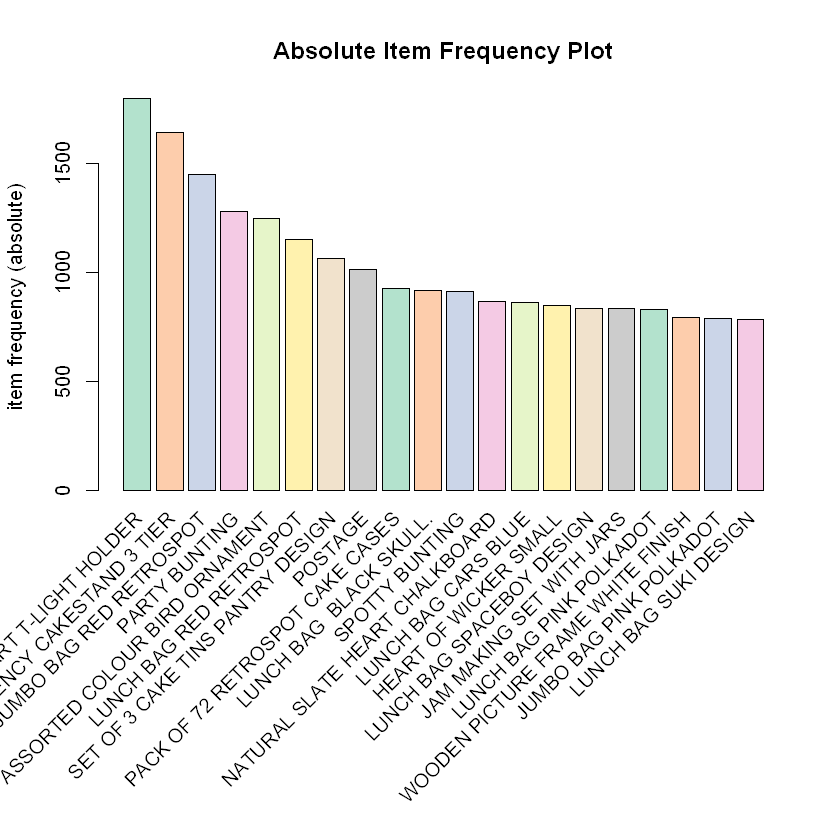

In [18]:
# Plot dos itens mais frequentemente comprados
itemFrequencyPlot(tr,topN=20,type="absolute",col=brewer.pal(8,'Pastel2'), main="Absolute Item Frequency Plot")

In [19]:
# Criando regras com apriori
association.rules = apriori(tr, parameter = list(supp=0.001, conf=0.8,maxlen=10))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5   0.001      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 18 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[7887 item(s), 18839 transaction(s)] done [0.15s].
sorting and recoding items ... [2455 item(s)] done [0.01s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10

Warning message in apriori(tr, parameter = list(supp = 0.001, conf = 0.8, maxlen = 10)):
"Mining stopped (maxlen reached). Only patterns up to a length of 10 returned!"


 done [0.43s].
writing ... [116493 rule(s)] done [0.06s].
creating S4 object  ... done [0.10s].


In [20]:
# Visualizar 10 primeiras regras
options(digits=2)
association.rules = sort(association.rules, by="confidence", decreasing=TRUE)
inspect(association.rules[1:10])

     lhs                         rhs                support confidence coverage
[1]  {WOBBLY CHICKEN}         => {METAL}            0.0015  1          0.0015  
[2]  {WOBBLY CHICKEN}         => {DECORATION}       0.0015  1          0.0015  
[3]  {DECOUPAGE}              => {GREETING CARD}    0.0012  1          0.0012  
[4]  {BILLBOARD FONTS DESIGN} => {WRAP}             0.0015  1          0.0015  
[5]  {WOBBLY RABBIT}          => {METAL}            0.0018  1          0.0018  
[6]  {WOBBLY RABBIT}          => {DECORATION}       0.0018  1          0.0018  
[7]  {ART LIGHTS}             => {FUNK MONKEY}      0.0020  1          0.0020  
[8]  {FUNK MONKEY}            => {ART LIGHTS}       0.0020  1          0.0020  
[9]  {CHOCOLATE  SPOTS}       => {SWISS ROLL TOWEL} 0.0023  1          0.0023  
[10] {BLACK TEA}              => {SUGAR JARS}       0.0024  1          0.0024  
     lift count
[1]  377  28   
[2]  377  28   
[3]  331  23   
[4]  608  29   
[5]  377  34   
[6]  377  34   
[7]  496

In [21]:
# Remoção de regras redundantes
subset.rules = which(colSums(is.subset(association.rules, association.rules)) > 1)
subset.association.rules. = association.rules[-subset.rules]

In [22]:
# Foram removidas 107.755 regras e restaram 8.738
length(association.rules)
length(subset.rules)
length(subset.association.rules.)

[1] 116493

[1] 107755

[1] 8738

## **Análise dos resultados**



**Before buying metal, people bought...**

In [23]:
# Criação da regra para o item METAL (rhs = METAL)
metal.association.rules = apriori(tr, parameter = list(supp=0.001, conf=0.8),appearance = list(default="lhs",rhs="METAL"), control = list(verbose=F))
inspect(head(metal.association.rules))

    lhs                            rhs     support confidence coverage lift
[1] {WOBBLY CHICKEN}            => {METAL} 0.0015  1          0.0015   377 
[2] {WOBBLY RABBIT}             => {METAL} 0.0018  1          0.0018   377 
[3] {DECORATION}                => {METAL} 0.0027  1          0.0027   377 
[4] {DECORATION,WOBBLY CHICKEN} => {METAL} 0.0015  1          0.0015   377 
[5] {DECORATION,WOBBLY RABBIT}  => {METAL} 0.0018  1          0.0018   377 
    count
[1] 28   
[2] 34   
[3] 50   
[4] 28   
[5] 34   


**People who bought metal, also bought...**

In [24]:
# Criação de regra para o item METAL (lhs = METAL)
metal.association.rules = apriori(tr, parameter = list(supp=0.001, conf=0.8),appearance = list(lhs="METAL", default="rhs"), control = list(verbose=F))
inspect(head(metal.association.rules))

    lhs        rhs          support confidence coverage lift count
[1] {METAL} => {DECORATION} 0.0027  1          0.0027   377  50   


## **Visualização**



### **Scatterplot**

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



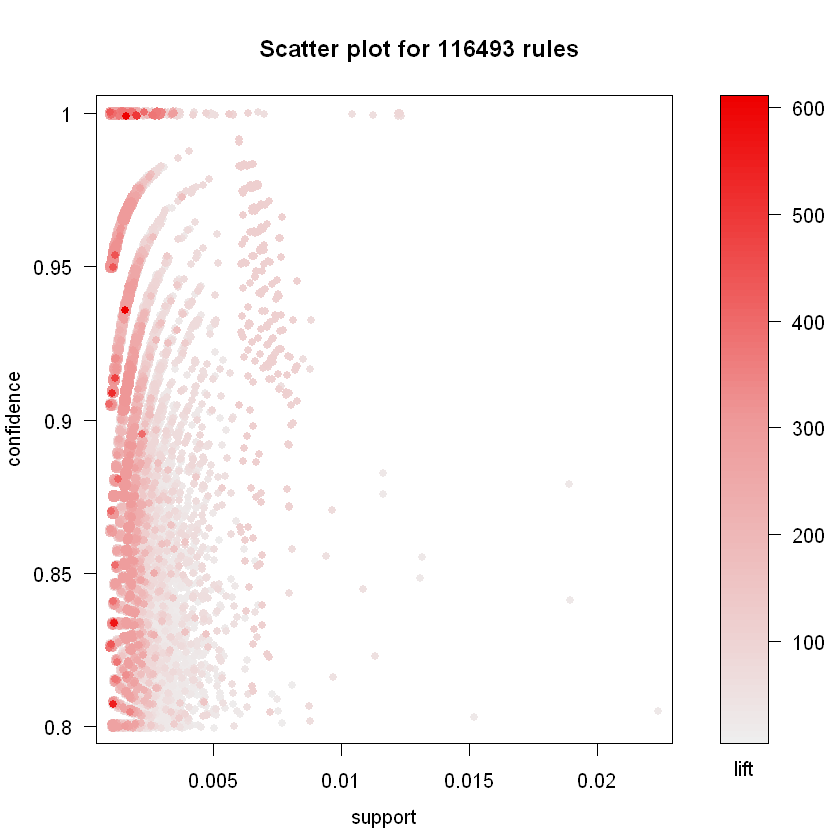

In [25]:
# Scatterplot simples(gradiente de cores)
subRules = association.rules[quality(association.rules)$confidence>0.4]
plot(subRules)

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



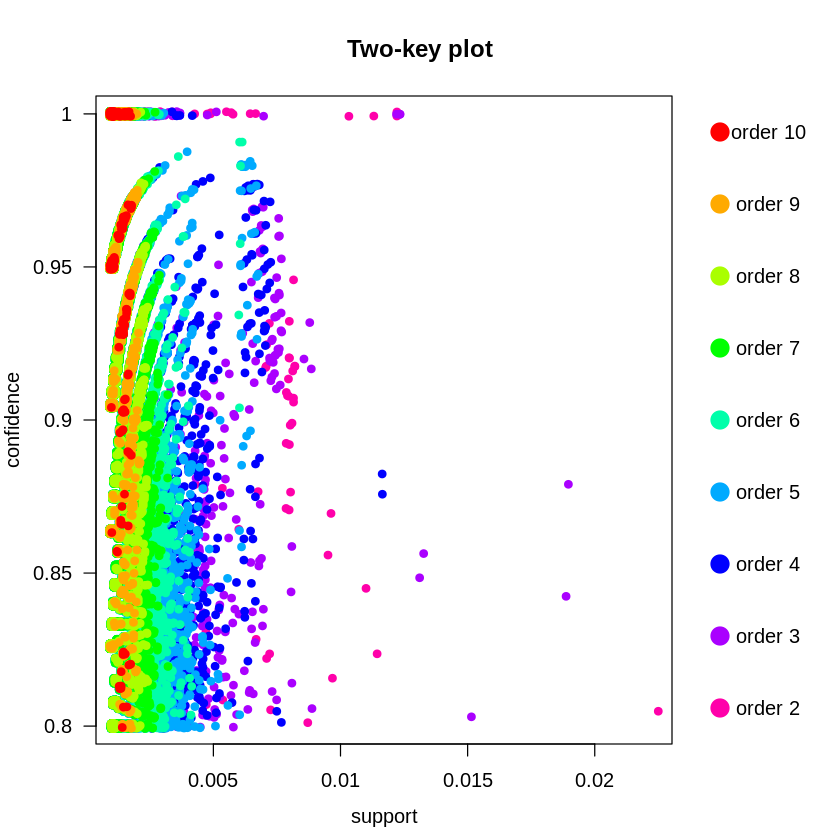

In [80]:
# Scatterplot com mais contraste
plot(subRules,method="two-key plot")

### **Gráficos**

In [27]:
# Não funciona no google colab - executar no júpiter notebook
top10subRules = head(subRules, n = 10, by = "confidence")
plot(top10subRules, method = "graph",  engine = "htmlwidget")

HTML widgets cannot be represented in plain text (need html)

### **Regras individuais**

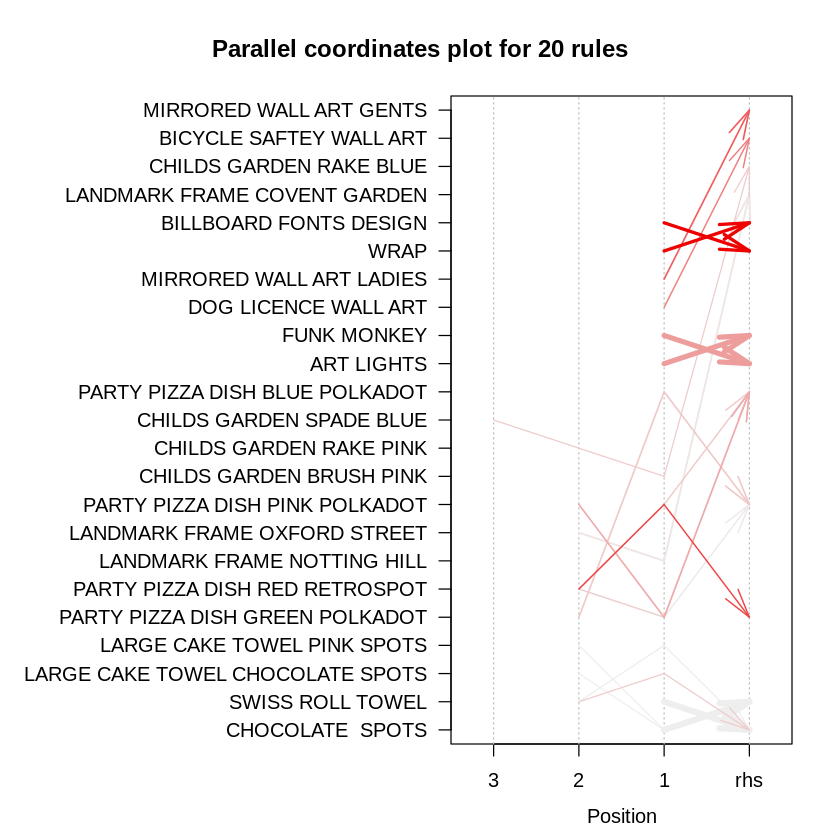

In [61]:
# Regar de setas (não muito visual)
subRules2 = head(subRules, n=20, by="lift")
plot(subRules2, method="paracoord")